In [15]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


# Utilitzant un Model Existent

Se ha decidit utilitzar el model Resnet50 després de mirar la comparació de models de classificació d'imatges al següent [enllaç](https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/).

A continuació carregam les imatges del dataset per poder utilitzarles.

## Càrrega de Dades

Càlcul de la mitjana i desviació típica per a poder transformar les dades.

In [16]:
data_dir = './data/'
model_dir = './models/existent/'
input_size = 224 # Tamany d'imatge que utiliza Resnet
batch_size = 32

In [17]:
# transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor()
#     ])

# # dataset = datasets.ImageNet(".", split="train", transform=transform)
# dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)

# means = []
# stds = []
# for img, label in dataset:
#     means.append(torch.mean(img))
#     stds.append(torch.std(img))

# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))
# print(f'{mean=}, {std=}')

In [18]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5098), (0.2212)) # mitjana, desviacio tipica
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5098), (0.2212)) # mitjana, desviacio tipica
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Funcions Auxiliars

In [19]:
def init_model(num_classes, feature_extract, weights=None):
    model = models.resnet18(weights=weights)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [20]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, filename=None):
    since = time.time()
    tra_acc_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # append accuracies
            if phase == 'train':
                tra_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if filename != None:
        torch.save(model.state_dict(), os.path.join(model_dir, filename))
    return model, tra_acc_history, val_acc_history

## Model Preentrenat

En aquest apartat provam l'arquitectura del model Resnet50 utilitzant els pesos preentrenats amb el dataset ImageNet.

Només modificam els valors de la darrera capa per a que faci una classificació binaria ja que només tenim 2 labels.

### Define Model

In [21]:
model = init_model(num_classes=2, feature_extract=True, weights=models.ResNet18_Weights.DEFAULT)
model = model.to(device)

In [22]:
model_parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Params to be trained: {params}')

Params to be trained: 1026


### Train Model

In [23]:
num_epochs = 15

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, pt_tra_acc, pt_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, 'resnet18_pretrained.pth')

Epoch 0/14
----------
train Loss: 0.3480 Acc: 0.8832
val Loss: 0.1796 Acc: 0.9492

Epoch 1/14
----------
train Loss: 0.1112 Acc: 0.9776
val Loss: 0.1590 Acc: 0.9453

Epoch 2/14
----------
train Loss: 0.0900 Acc: 0.9825
val Loss: 0.1345 Acc: 0.9570

Epoch 3/14
----------
train Loss: 0.0778 Acc: 0.9815
val Loss: 0.1132 Acc: 0.9648

Epoch 4/14
----------
train Loss: 0.0742 Acc: 0.9796
val Loss: 0.1374 Acc: 0.9570

Epoch 5/14
----------
train Loss: 0.0654 Acc: 0.9844
val Loss: 0.1136 Acc: 0.9609

Epoch 6/14
----------
train Loss: 0.0666 Acc: 0.9786
val Loss: 0.0854 Acc: 0.9727

Epoch 7/14
----------
train Loss: 0.0570 Acc: 0.9796
val Loss: 0.0782 Acc: 0.9766

Epoch 8/14
----------
train Loss: 0.0681 Acc: 0.9786
val Loss: 0.1368 Acc: 0.9531

Epoch 9/14
----------
train Loss: 0.0753 Acc: 0.9757
val Loss: 0.1411 Acc: 0.9531

Epoch 10/14
----------
train Loss: 0.0568 Acc: 0.9844
val Loss: 0.0602 Acc: 0.9766

Epoch 11/14
----------
train Loss: 0.0640 Acc: 0.9786
val Loss: 0.0710 Acc: 0.9727

Ep

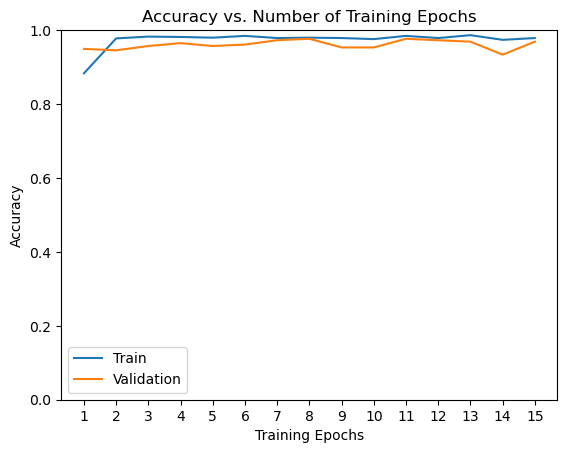

In [24]:
train = [h.cpu().numpy() for h in pt_tra_acc]
val = [h.cpu().numpy() for h in pt_val_acc]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train,label="Train")
plt.plot(range(1,num_epochs+1),val,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Model Reentrenat

In [25]:
model = init_model(num_classes=2, feature_extract=False, weights=None)
model = model.to(device)

In [26]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Params to be trained: {params}')

Params to be trained: 11177538


In [27]:
num_epochs = 15

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, t_tra_acc, t_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, filename='resnet18_retrained.pth')

Epoch 0/14
----------
train Loss: 0.6577 Acc: 0.5988
val Loss: 1.0840 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.5131 Acc: 0.7390
val Loss: 4.0542 Acc: 0.5000

Epoch 2/14
----------
train Loss: 0.4243 Acc: 0.8140
val Loss: 0.9035 Acc: 0.6523

Epoch 3/14
----------
train Loss: 0.3267 Acc: 0.8676
val Loss: 4.6595 Acc: 0.5000

Epoch 4/14
----------
train Loss: 0.3036 Acc: 0.8685
val Loss: 0.8213 Acc: 0.6328

Epoch 5/14
----------
train Loss: 0.3488 Acc: 0.8588
val Loss: 1.0367 Acc: 0.6484

Epoch 6/14
----------
train Loss: 0.2375 Acc: 0.9094
val Loss: 0.8452 Acc: 0.6641

Epoch 7/14
----------
train Loss: 0.2013 Acc: 0.9309
val Loss: 0.9270 Acc: 0.6562

Epoch 8/14
----------
train Loss: 0.2439 Acc: 0.9065
val Loss: 1.2511 Acc: 0.5820

Epoch 9/14
----------
train Loss: 0.1930 Acc: 0.9328
val Loss: 1.3013 Acc: 0.6289

Epoch 10/14
----------
train Loss: 0.1941 Acc: 0.9192
val Loss: 2.6576 Acc: 0.5156

Epoch 11/14
----------
train Loss: 0.2492 Acc: 0.8909
val Loss: 1.2475 Acc: 0.5078

Ep

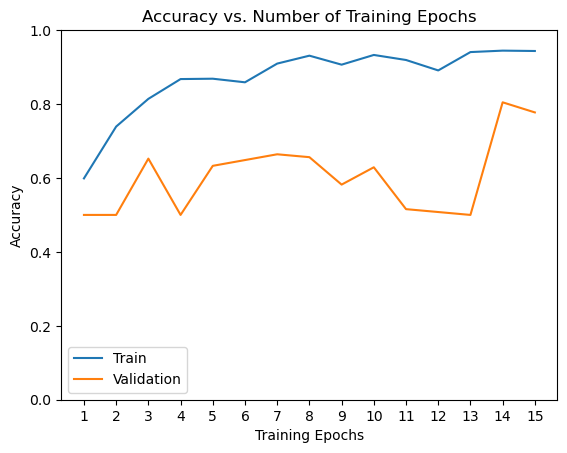

In [28]:
train = [h.cpu().numpy() for h in t_tra_acc]
val = [h.cpu().numpy() for h in t_val_acc]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train,label="Train")
plt.plot(range(1,num_epochs+1),val,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Com podem veure la accuracy durant la validació es molt menor que la de l'entrenament. Aixó pot ser ja que el model senser es massa complex per a la poca cantidad d'imatges que tenim. En canvi amb els pesos del ImageNet al tenir moltes mes imatges pot separar molt mes facilment les caracteristiques de les imatges i després fent un reentrament de la detecció de les features que ens interesen podem obtenir un resultat molt millor.

## Comparació

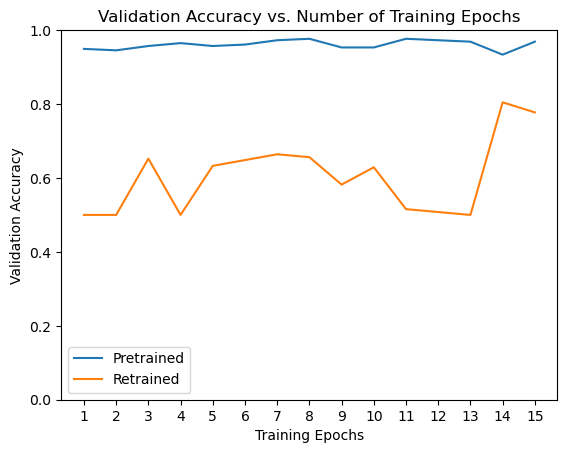

In [29]:
pretrained = [h.cpu().numpy() for h in pt_val_acc]
retrained = [h.cpu().numpy() for h in t_val_acc]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),pretrained,label="Pretrained")
plt.plot(range(1,num_epochs+1),retrained,label="Retrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Com podem observar s'obté un molt millor resultat utilitzant els pesos preentrenats.